In [2]:
import xarray as xr
import s3fs

In [3]:
fs_s3 = s3fs.S3FileSystem(anon=False)

In [4]:
path = 's3://gdas-data/'

In [5]:
flist1 = fs_s3.glob(path+'temp_06.nc')
flist2 = fs_s3.glob(path+'tpw_06.nc')

In [6]:
print(flist1)
print(flist2)

['gdas-data/temp_06.nc']
['gdas-data/tpw_06.nc']


In [7]:
s3path1 = 's3://'+flist1[0]
s3path2 = 's3://'+flist2[0]

In [8]:
remote_file_obj1 = fs_s3.open(s3path1, mode='rb')
remote_file_obj2 = fs_s3.open(s3path2, mode='rb')

In [9]:
ds_temp = xr.open_dataset(remote_file_obj1)
ds_tpw = xr.open_dataset(remote_file_obj2)

In [10]:
ds_temp

<xarray.Dataset>
Dimensions:  (time: 1332, lat: 65, lon: 37)
Dimensions without coordinates: time, lat, lon
Data variables:
    temp     (time, lat, lon) float64 ...
    date     (time) datetime64[ns] ...

In [11]:
ds_tpw

<xarray.Dataset>
Dimensions:  (time: 1332, lat: 65, lon: 37)
Dimensions without coordinates: time, lat, lon
Data variables:
    tpw      (time, lat, lon) float64 ...
    date     (time) datetime64[ns] ...

In [12]:
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

In [13]:
def bilinear_interpolation(lat, lon, data_array_orig):
    
    #flip image upside down before interpolation
    data_array = np.flipud(data_array_orig)

    latitudes = np.arange(65) * 0.25 + 5
    longitudes = np.arange(37) * 0.25 + 97

    lat_index = int((lat - 5.0) / 0.25)
    lon_index = int((lon - 97.0) / 0.25)

    #print(lat_index,lon_index)
    lat_index0 = lat_index
    lat_index1 = lat_index + 1
    if lat_index1 > 64:
        lat_index1= 64
        
    lon_index0 = lon_index
    lon_index1 = lon_index + 1
    if lon_index1 > 36:
        lon_index1 = 36
    
    
    lat_fraction = (lat - latitudes[lat_index]) / 0.25
    lon_fraction = (lon - longitudes[lon_index]) / 0.25

    #print(lat_fraction,lon_fraction)
    
    
    # top_left = data_array[lat_index, lon_index]
    # top_right = data_array[lat_index, lon_index + 1]
    top_left = data_array[lat_index0, lon_index0]
    top_right = data_array[lat_index0, lon_index1]

    #print(top_left,top_right)
    
    # bottom_left = data_array[lat_index + 1, lon_index]
    # bottom_right = data_array[lat_index + 1, lon_index + 1]
    bottom_left = data_array[lat_index1, lon_index0]
    bottom_right = data_array[lat_index1, lon_index1]

    #print(bottom_left, bottom_right)
    
    interpolated_value = (1 - lon_fraction) * (1 - lat_fraction) * top_left \
                         + lon_fraction * (1 - lat_fraction) * top_right \
                         + (1 - lon_fraction) * lat_fraction * bottom_left \
                         + lon_fraction * lat_fraction * bottom_right
    
    return round(interpolated_value,2)

In [14]:
def para_plot(latitude, longitude, ds_x, para, title):

    #filename = 'heatidx_012020_072023_06.nc'
    ds = ds_x

    start_date = '2020-01-01'
    end_date = '2023-09-01'


    # Convert date strings to datetime.date objects
    start_date_obj = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date_obj = datetime.strptime(end_date, '%Y-%m-%d').date()

    # Create a boolean mask for the date range
    mask = (ds['date'].dt.date >= start_date_obj) & (ds['date'].dt.date <= end_date_obj)

    filtered_ds = ds.sel(time=mask)

    hi_data = filtered_ds[para].squeeze()
    hi_time = filtered_ds['date']


    # INPUT LATITUDE, LONGITUDE OF INTEREST
    # latitude = 16.43
    # longitude = 100.12

    lat_str = str(latitude)
    lon_str = str(longitude)

    # Assuming hi_data is a NumPy array of shape (num_samples, 65, 37)
    num_samples = hi_data.shape[0]
    # hi_loc = np.zeros(num_samples)
    # timestamp_array = np.zeros(num_samples)

    heat_index_array = []
    timestamp_array = []

    for i in range(num_samples):
        fdata = hi_data[i, :, :].squeeze()
        fdata_loc = bilinear_interpolation(latitude, longitude, fdata)
        fdata_loc_c = fdata_loc
        #fdata_loc_c = 5.0/9.0*(fdata_loc - 32.0)

        heat_index_array.append(round(fdata_loc_c,2))

        timestamp = hi_time[i].dt.date
        timestamp_array.append(timestamp.values)
        # hi_loc[i] = fdata_loc
        # timestamp_array[i] = hi_time[i]

    data = {'date': timestamp_array, 'para': heat_index_array}
    df = pd.DataFrame(data)

    df.set_index('date', inplace=True)


    # Assuming df is your DataFrame with 'heat_index' column and datetime index
    plt.figure(figsize=(10, 6))

    # Convert datetime index to numerical values
    x_values = mdates.date2num(df.index)

    plt.plot(x_values, df['para'], marker='.')
    plt.title(f'{title} at ({lat_str}, {lon_str}), 06:00 UTC',fontsize=20)
    plt.xlabel('Date')
    plt.ylabel(title)
    plt.grid(True)

    # Format x-axis labels as dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotate x-axis labels for better readability
    plt.gcf().autofmt_xdate()

    #plt.savefig('test.png', dpi=200, bbox_inches='tight')
    #plt.show()

    return timestamp_array, heat_index_array

In [15]:
def para_predict(latitude, longitude, ds_x, para, ylim, title, start_date_training, end_date_training, start_date_testing, end_date_testing, fdays):
    
    #filename = 'heatidx_012020_072023_06.nc'
    #ds = xr.open_dataset(filename)
    ds = ds_x
    
    start_date = '2020-01-01'
    end_date = '2023-09-01'


    # Convert date strings to datetime.date objects
    start_date_obj = datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date_obj = datetime.strptime(end_date, '%Y-%m-%d').date()
    

    # Create a boolean mask for the date range
    mask = (ds['date'].dt.date >= start_date_obj) & (ds['date'].dt.date <= end_date_obj)    

    filtered_ds = ds.sel(time=mask)
    
    hi_data = filtered_ds[para].squeeze()
    hi_time = filtered_ds['date']


    # INPUT LATITUDE, LONGITUDE OF INTEREST
    # latitude = 16.43
    # longitude = 100.12

    lat_str = str(latitude)
    lon_str = str(longitude)

    # Assuming hi_data is a NumPy array of shape (num_samples, 65, 37)
    num_samples = hi_data.shape[0]
    # hi_loc = np.zeros(num_samples)
    # timestamp_array = np.zeros(num_samples)

    heat_index_array = []
    timestamp_array = []

    for i in range(num_samples):
        fdata = hi_data[i, :, :].squeeze()
        fdata_loc = bilinear_interpolation(latitude, longitude, fdata)
        #fdata_loc_c = 5.0/9.0*(fdata_loc - 32.0)
        fdata_loc_c = fdata_loc
        
        heat_index_array.append(round(fdata_loc_c,2))

        timestamp = hi_time[i].dt.date
        timestamp_array.append(timestamp.values)
        # hi_loc[i] = fdata_loc
        # timestamp_array[i] = hi_time[i]

    #prediction start here
    ds, y = timestamp_array, heat_index_array

    date_list = [dt.item() for dt in ds]
    y_list = y

    data = {'ds': date_list, 'y': y_list}
    df2 = pd.DataFrame(data)

    #####################################
    df3 = df2.copy()
    df3['ds'] = pd.to_datetime(df2['ds'])
    
    # start_date_training = '2021-02-01'
    # end_date_training = '2022-11-30'
    # Filter the DataFrame based on the time period
    training_df = df3[(df3['ds'] >= start_date_training) & (df3['ds'] <= end_date_training)]
    testing_df = df3[(df3['ds'] >= start_date_testing) & (df3['ds'] <= end_date_testing)]

    
    
    m = Prophet()
    #m.fit(df2)
    m.fit(training_df)
    
    future = m.make_future_dataframe(periods=fdays)
    forecast = m.predict(future)
    
    # Plot forecast
    fig = m.plot(forecast)
    plt.xlabel('Date')
    plt.ylabel(title)
    #plt.ylim([0,120])
    plt.ylim(ylim)
    #plt.title('Heat Index, '+city_name)
    plt.title(f'{title} at ({lat_str}, {lon_str}), 06:00 UTC',fontsize=20)

    # Format x-axis ticks to show year and specific months (January and July)
    date_format = mdates.DateFormatter('%Y-%b')
    plt.gca().xaxis.set_major_formatter(date_format)

    # Set the locator to show ticks only for January and July
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))

    plt.gcf().autofmt_xdate()

    #plt.savefig('test_predict.png', dpi=200, bbox_inches='tight')
    plt.show()

    return forecast, training_df, testing_df

In [16]:
lat = 15.7241
lon = 100.3972
lat_str = str(lat)
lon_str = str(lon)

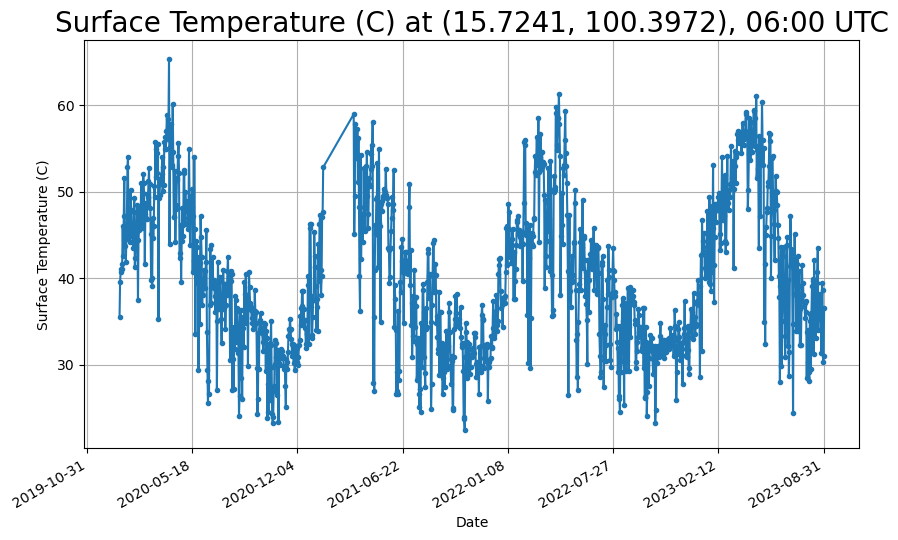

In [17]:
ds, y = para_plot(lat,lon,ds_temp,'temp','Surface Temperature (C)')

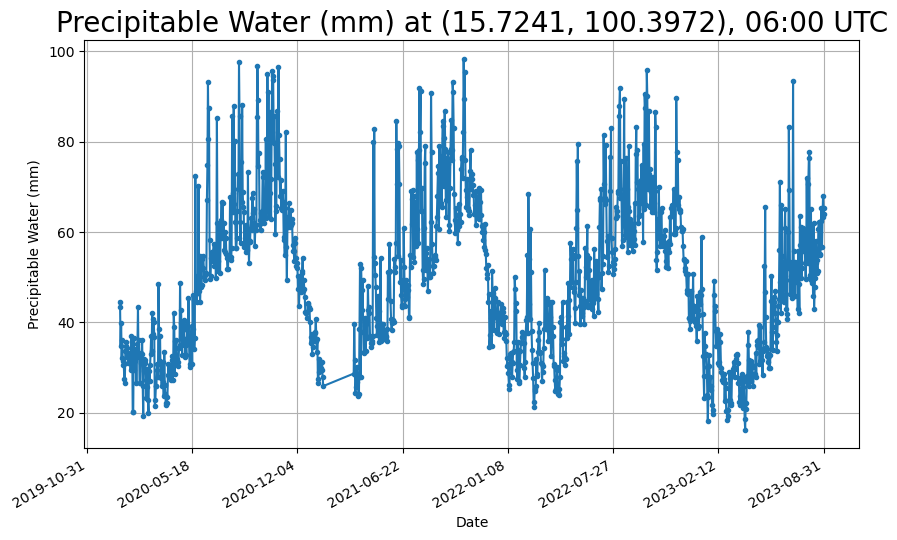

In [18]:
ds, y = para_plot(lat,lon,ds_tpw,'tpw','Precipitable Water (mm)')

In [19]:
from prophet import Prophet

In [20]:
start_date_training = '2020-01-01'
end_date_training = '2023-06-30'

start_date_testing = '2023-07-01'
end_date_testing = '2023-09-01'

predict_days = 365

18:39:09 - cmdstanpy - INFO - Chain [1] start processing
18:39:09 - cmdstanpy - INFO - Chain [1] done processing


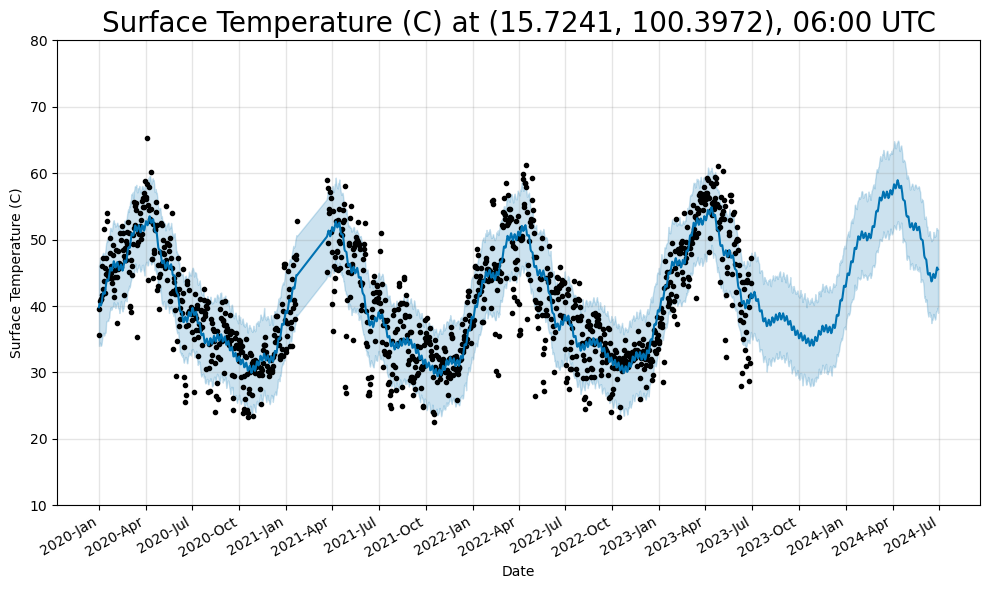

In [21]:
title = 'Surface Temperature (C)'
forecast_df, training_df, testing_df = para_predict(lat, lon, ds_temp, 'temp', [10,80], title, start_date_training, end_date_training, start_date_testing, end_date_testing, predict_days)

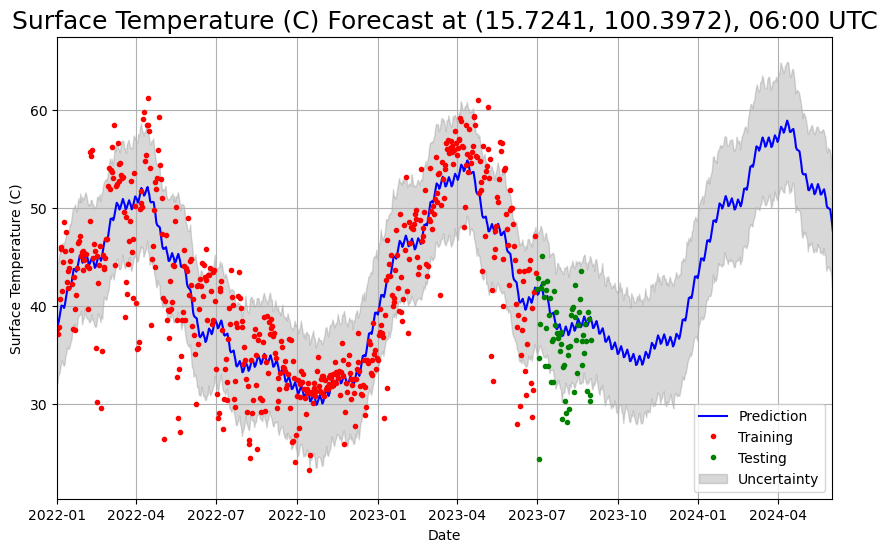

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['ds'], forecast_df['yhat'], color='blue', label='Prediction')

plt.plot(training_df['ds'], training_df['y'], color='red', marker='.', linestyle='', label='Training')
plt.plot(testing_df['ds'], testing_df['y'], color='green', marker='.', linestyle='', label='Testing')

plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'],
                 color='gray', alpha=0.3, label='Uncertainty')

# Setting x-axis label, y-axis label, and plot title
plt.xlabel('Date')
plt.ylabel(title)
plt.title(f'{title} Forecast at ({lat_str}, {lon_str}), 06:00 UTC', fontsize=18)

start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2024-06-01')
plt.xlim(start_date, end_date)

# Adding legend and grid
plt.legend()
plt.grid(True)

#plt.savefig('heatindex_predict_testing_cm.png', dpi=200, bbox_inches='tight')
plt.savefig('surface_temp_pred.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()


In [23]:
filtered_df = forecast_df[(forecast_df['ds'] >= start_date_testing) & (forecast_df['ds'] <= end_date_testing)]

lower_bounds = filtered_df['yhat_lower'].values
upper_bounds = filtered_df['yhat_upper'].values

count_points_between_bounds = []

# Loop through each row in 'testing_df' and count points between bounds
for y_value in testing_df['y']:
    count = int(any((y_value >= lower_bounds) & (y_value <= upper_bounds)))
    count_points_between_bounds.append(count)

total_hit = sum(count_points_between_bounds)
total_count = len(lower_bounds)
accuracy = total_hit*100.0/total_count
print(accuracy)

92.06349206349206


18:39:13 - cmdstanpy - INFO - Chain [1] start processing
18:39:13 - cmdstanpy - INFO - Chain [1] done processing


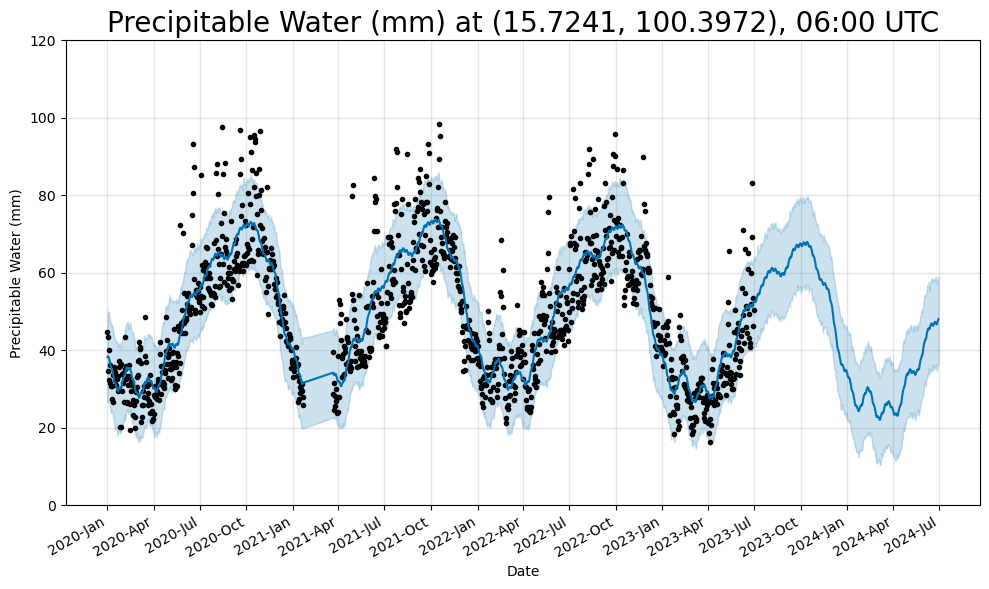

In [24]:
title = 'Precipitable Water (mm)'
forecast_df, training_df, testing_df = para_predict(lat, lon, ds_tpw, 'tpw', [0,120], title, start_date_training, end_date_training, start_date_testing, end_date_testing, predict_days)

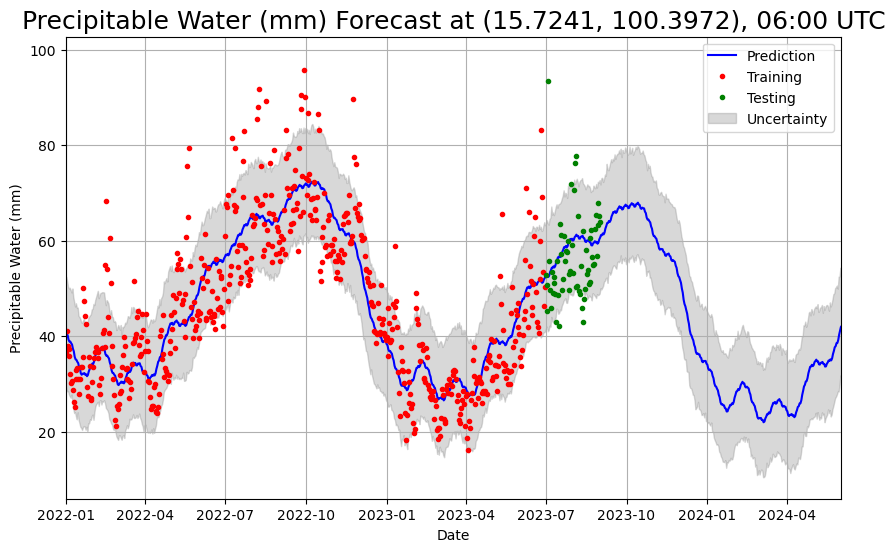

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['ds'], forecast_df['yhat'], color='blue', label='Prediction')

plt.plot(training_df['ds'], training_df['y'], color='red', marker='.', linestyle='', label='Training')
plt.plot(testing_df['ds'], testing_df['y'], color='green', marker='.', linestyle='', label='Testing')

plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'],
                 color='gray', alpha=0.3, label='Uncertainty')

# Setting x-axis label, y-axis label, and plot title
plt.xlabel('Date')
plt.ylabel(title)
plt.title(f'{title} Forecast at ({lat_str}, {lon_str}), 06:00 UTC', fontsize=18)

start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2024-06-01')
plt.xlim(start_date, end_date)

# Adding legend and grid
plt.legend()
plt.grid(True)

#plt.savefig('heatindex_predict_testing_cm.png', dpi=200, bbox_inches='tight')
#plt.savefig('heatindex_predict_training_cm.png', dpi=200, bbox_inches='tight')
plt.savefig('tpw_pred.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()


In [26]:
filtered_df = forecast_df[(forecast_df['ds'] >= start_date_testing) & (forecast_df['ds'] <= end_date_testing)]

lower_bounds = filtered_df['yhat_lower'].values
upper_bounds = filtered_df['yhat_upper'].values

count_points_between_bounds = []

# Loop through each row in 'testing_df' and count points between bounds
for y_value in testing_df['y']:
    count = int(any((y_value >= lower_bounds) & (y_value <= upper_bounds)))
    count_points_between_bounds.append(count)

total_hit = sum(count_points_between_bounds)
total_count = len(lower_bounds)
accuracy = total_hit*100.0/total_count
print(accuracy)

95.23809523809524
